In [1]:
# imageio
import imageio

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import gc


def get_vehicle_corners(x, y, yaw, length, width):
    # Calculate rear center position
    # rear_x = x - (length / 2) * np.cos(np.radians(yaw))
    # rear_y = y - (length / 2) * np.sin(np.radians(yaw))
    
    # Calculate corner points
    corners_x = [x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Front Right
                 x + (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Front Left
                 x - (length / 2) * np.cos(np.radians(yaw)) + (width / 2) * np.sin(np.radians(yaw)), # Rear Left
                 x - (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw)), # Rear Right
                 x + (length / 2) * np.cos(np.radians(yaw)) - (width / 2) * np.sin(np.radians(yaw))]
    
    corners_y = [y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Front Right
                 y + (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Front Left
                 y - (length / 2) * np.sin(np.radians(yaw)) - (width / 2) * np.cos(np.radians(yaw)), # Rear Left
                 y - (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw)), # Rear Right
                 y + (length / 2) * np.sin(np.radians(yaw)) + (width / 2) * np.cos(np.radians(yaw))]
    
    return corners_x, corners_y

# Animation function
def animate(i):
    global First_crossed
    global ax
    global ax2
    global data
    ax.clear()
    ax2.clear()

    # Flip the x and y axis limits
    # ax.set_ylim(min(min(data.x_FV), min(data.x_MV)) - 10, max(max(data.x_FV), max(data.x_MV)) + 10)
    # ax.set_xlim(min(min(data.y_FV), min(data.y_MV)) - 10, max(max(data.y_FV), max(data.y_MV)) + 10)
    ax.set_ylim(5, 22)
    ax.set_xlim(-180,-20)
    
    # Draw lanes as horizontal dashed lines instead of vertical
    for lane_y in [9.9, 13.3, 16.8]:
        ax.axhline(y=lane_y, color='gray', linestyle='--')
    
    # Get vehicle corners for each car and flip x and y coordinates for plotting
    if 'Yaw_FV' in data.columns:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], data['Yaw_FV'].iloc[i], vehicle_length, vehicle_width)
    else:
        corners_x_FV, corners_y_FV = get_vehicle_corners(data['x_FV'].iloc[i], data['y_FV'].iloc[i], -90.29, vehicle_length, vehicle_width)
    corners_x_MV, corners_y_MV = get_vehicle_corners(data['x_MV'].iloc[i],data['y_MV'].iloc[i],  data['Yaw_MV'].iloc[i], vehicle_length, vehicle_width)
    if 'x_LV' in data.columns and 'y_LV' in data.columns:
        corners_x_LV, corners_y_LV = get_vehicle_corners(data['x_LV'].iloc[i],data['y_LV'].iloc[i],  -90.29, vehicle_length, vehicle_width)
        ax.plot(corners_y_LV, corners_x_LV, 'c')  # Flip x and y
    
    # Plot Following Vehicle (FV) and Merging Vehicle (MV) with flipped axes
    ax.plot(corners_y_FV, corners_x_FV, 'r')  # Flip x and y
    ax.plot(corners_y_MV, corners_x_MV, 'b')  # Flip x and y
    
    # Draw lane drop guard
    ax.plot([-175, -169], [13.3, 16.8], color='black')
    
    ax.set_title(f"Time: {data['Time'].iloc[i]:.2f}")

    if First_crossed is None:
        for j in range(len(data)):
            corners_x_MV, _ = get_vehicle_corners(data['x_MV'].iloc[j], data['y_MV'].iloc[j], data['Yaw_MV'].iloc[j], vehicle_length, vehicle_width)
            # 전방 왼쪽 꼭지점은 corners_x_MV[1]을 사용하여 접근
            if corners_x_MV[1] < 13.3:
                First_crossed = data['Time'].iloc[j]
                break

    # 두 번째 그래프(Interacting possibility) 설정
    # ax2.plot(data['Time'], data['P_beta'], color='#FF8C00',label='Beta')
    ax2.plot(data['Time'], data['Interacting possibility'], color='#9400D3',label='Logit')
    if First_crossed is not None:
        ax2.axvline(x=First_crossed, color='blue', linestyle='--', linewidth=2)
    ax2.set_ylim(-0.1, 1.1)  # Interacting possibility의 범위 설정
    ax2.set_xlim(data['Time'].iloc[0]-1, data['Time'].iloc[-1]+1)
    ax2.legend(fontsize = 15)

    # LeftBlinker_MV가 True인 지점 표시
    # blinker_on_data = data[data['LeftBlinker_MV']]
    # for time in blinker_on_data['Time']:
    #     ax2.axvline(x=time, color='lightgreen', alpha=0.5)
    
    # 현재 시점 표시
    current_time = data['Time'].iloc[i]
    ax2.axvline(x=current_time, color='black')

# Define vehicle dimensions
vehicle_length = 4.18  # meters
vehicle_width = 1.99  # meters

START = False
images = []


In [15]:
def generating_gif(i):
    global data
    global ax
    global ax2
    global First_crossed
    # folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
    folder_path = Path('./DS_experiment_data/AV path planning experiment/박현철/')
    csv_files = folder_path.glob('*.csv')
    images = []
    START = False
    i = 0
    How_many = None
    for file_path in csv_files:
        # if file_path == Path('./DS_experiment_data\AV path planning experiment\남동하\BaseLine_10_20_60_failure_1.csv'):
        #     print(file_path, 'Already Done')
        #     START = True
        #     continue
        # if not START:
        #     print(file_path, 'Already Done')
        #     continue

        # Initialize
        data = pd.DataFrame()
        images.clear()
        gc.collect()
        SUCCESS = None
        First_crossed = None
        # Read the last row of the current CSV file
        data = pd.read_csv(file_path)

        # 예측하고 결과 저장
        data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), ['P_beta', 'P_logistic']] = np.nan

        if data['y_MV'].iloc[-1] < data['y_FV'].iloc[-1]:
            SUCCESS = True
        else:
            SUCCESS = False

        file_name = os.path.basename(file_path)
        file_name = file_name.replace('.csv','')
        # Setup figure and axis
        
        # width = 4*(max(max(data.y_FV), max(data.y_MV)) + 10-min(min(data.y_FV), min(data.y_MV)) + 10)/(max(max(data.x_FV), max(data.x_MV)) + 10 - min(min(data.x_FV), min(data.x_MV)) + 10)
        width = 30
        # Creating animation
        images = []
        for j in range(len(data)):
            fig, axs = plt.subplots(2,1,figsize=(width, 8))
            ax = axs[0]
            ax2 = axs[1]
            animate(j)
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)
            plt.close()
        # if SUCCESS:
        #     imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_success.gif',images, writer='imagemagick' ,loop=0, fps=20)
        # else:
        #     imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_failure.gif',images, writer='imagemagick', loop=0, fps=20)
        destination_path = folder_path.joinpath(file_name).with_suffix('.gif')
        imageio.mimsave(destination_path,images, writer='imagemagick' ,loop=0, fps=20)
        print(file_path,'DONE')
        plt.close()  # Prevent extra static plot from displaying
        i+=1
        if How_many and i>=How_many:
            break


C:\Users\User\AppData\Local\Temp\ipykernel_137040\2054341829.py:37: RuntimeWarning: divide by zero encountered in divide
  TTC = D / S  # TTC 계산


                              BetaModel Results                               
Dep. Variable:                      p   Log-Likelihood:                 24.844
Model:                      BetaModel   AIC:                            -41.69
Method:            Maximum Likelihood   BIC:                            -40.90
Date:                Thu, 09 May 2024                                         
Time:                        19:36:02                                         
No. Observations:                   9                                         
Df Residuals:                       5                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2382      0.627     -0.380      0.704      -1.466       0.990
distance       0.2436      0.029      8.385      0.0

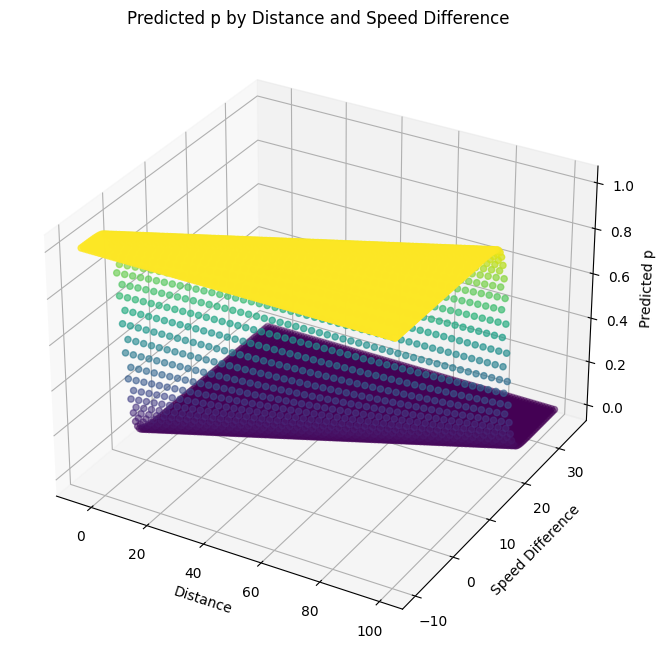

In [3]:
# Beta regression

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
import matplotlib.pyplot as plt

distance = np.array([20, 20, 20, 30, 30, 30, 40, 40, 40])
speed_diff = np.array([20, 30, 40, 20, 30, 40, 20, 30, 40]) / 3.6  # 변환된 속도 차이
p = 1 - np.array([0.9125, 1.0, 1.0, 0.3875, 0.975, 1.0, 0.0875, 0.5625, 1.0])  # 이벤트가 발생하지 않을 확률
p_adjusted = np.clip(p, 0.001, 0.999)
# p_adjusted = np.clip(p,(0.5)/len(p),(1*len(p)-1+0.5)/len(p))

# Preparing the dataset
df = pd.DataFrame({'distance': distance, 'speed_diff': speed_diff, 'TTC': distance/speed_diff,'p': p_adjusted})

X = df[['distance', 'speed_diff']]
# X = df[['TTC']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

y = df['p']
# Initialize and fit the beta regression model
model = BetaModel(endog=y, exog=X)
results = model.fit()
distance_Test = np.array([10,20,30,20,0])
speed_diff_Test = np.array([0.1,-10,-10,-20,-3])
TTC_test = distance_Test/speed_diff_Test
X_test = np.column_stack((np.ones(distance_Test.size),distance_Test.ravel(),speed_diff_Test.ravel()))

# 격자 생성을 위한 distance와 speed_diff의 범위 정의
distance_range = np.linspace(-5, 100, 100)
speed_diff_range = np.linspace(-10, 35, 100)

# 격자 생성
D, S = np.meshgrid(distance_range, speed_diff_range)
TTC = D / S  # TTC 계산
X_grid = np.column_stack((np.ones(D.size), D.ravel(), S.ravel()))  # 상수 항 포함
# X_grid = np.column_stack((np.ones(D.size), TTC.ravel()))

# 모델을 사용하여 격자 위의 지점들에 대한 p 예측
p_predicted = results.predict(X_grid)

# 3D 그래프 준비
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 예측된 p 값을 사용하여 3D 플롯 그리기
ax.scatter(D, S, p_predicted, c=p_predicted, cmap='viridis', marker='o')

ax.set_xlabel('Distance')
ax.set_ylabel('Speed Difference')
ax.set_zlabel('Predicted p')
plt.title('Predicted p by Distance and Speed Difference')
print(results.summary())
print(results.predict(X_test))
plt.show()

In [16]:
i=0
generating_gif(i)

DS_experiment_data\AV path planning experiment\박현철\BaseLine_10_10_50_failure.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_10_20_40_failure.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_10_30_40_failure.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_10_40_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_10_50_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_20_40_failure.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_20_50_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_20_60_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_20_30_40_failure.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_30_10_40_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\BaseLine_30_10_60_success.csv DONE
DS_experiment_data\AV path planning experiment\박현철\Bas

In [ ]:
i=2
folder_path = Path('./DS_experiment_data/Exp'+str(i)+'/')
csv_files = folder_path.glob('*.csv')

for file_path in csv_files:
    # if file_path == Path('./DS_experiment_data/Exp9/30_30_50_merging_scenario_data.csv'):
    #     print(file_path, 'Already Done')s
    #     START = True
    #     continue
    # if not START:
    #     print(file_path, 'Already Done')
    #     continue

    
    # Initialize
    data = pd.DataFrame()
    images.clear()
    gc.collect()
    SUCCESS = None
    First_crossed = None
    # Read the last row of the current CSV file
    data = pd.read_csv(file_path)

    # Possibility 치환, Filter possibility
    data['speed_diff'] = (data['speed_FV'] - data['speed_MV'])/3.6

    # 예측하고 결과 저장
    data['Interacting possibility'] = results.predict(sm.add_constant(data[['gap_btw_MV', 'speed_diff']]))
    data['Filtered_Interacting_possibility'] = data['Interacting possibility'].copy()
    data.loc[~((data['x_MV'] > 13.3) & (data['gap_btw_MV'] > -vehicle_length)), 'Filtered_Interacting_possibility'] = np.nan

    if data['y_MV'].iloc[-1] < data['y_FV'].iloc[-1]:
        SUCCESS = True
    else:
        SUCCESS = False

    file_name = os.path.basename(file_path)
    file_name = file_name.replace('.csv','')
    # Setup figure and axis
    
    width = 4*(max(max(data.y_FV), max(data.y_MV)) + 10-min(min(data.y_FV), min(data.y_MV)) + 10)/(max(max(data.x_FV), max(data.x_MV)) + 10 - min(min(data.x_FV), min(data.x_MV)) + 10)

    # Creating animation
    images = []
    for j in range(len(data)):
        fig, axs = plt.subplots(2,1,figsize=(width, 8))
        ax = axs[0]
        ax2 = axs[1]
        animate(j)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close()
    if SUCCESS:
        imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_success.gif',images, writer='imagemagick' ,loop=0, fps=20)
    else:
        imageio.mimsave('./DS_experiment_data/Exp'+str(i)+'/'+file_name+'_failure.gif',images, writer='imagemagick', loop=0, fps=20)
    print(file_path,'DONE')
    plt.close()  # Prevent extra static plot from displaying



DS_experiment_data\Exp2\Exp2_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp2\Exp2_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_30_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\

In [ ]:
i=1
generating_gif(i)

DS_experiment_data\Exp1\Exp1_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_10_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp1\Exp1_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_20_20_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp1\Exp1_20_20_50_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp1\Exp1_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp1\Exp1

In [ ]:
i=2
generating_gif(i)

DS_experiment_data\Exp2\Exp2_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_10_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_20_10_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp2\Exp2_20_30_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp2\Exp2_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\Exp2_30_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp2\

In [ ]:
i=3
generating_gif(i)

DS_experiment_data\Exp3\Exp3_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_10_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp3\Exp3_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_10_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp3\Exp3_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_20_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_20_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp3\Exp3_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_30_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp3\Exp3_30_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp3\Ex

In [ ]:
i=4
generating_gif(i)

DS_experiment_data\Exp4\Exp4_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_10_30_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp4\Exp4_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp4\Exp4_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_20_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp4\Exp4_3

In [ ]:
i=5
generating_gif(i)

DS_experiment_data\Exp5\Exp5_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_10_10_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp5\Exp5_10_10_40_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp5\Exp5_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_30_10_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp5\Exp5_30_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_30_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp5\Exp5_30_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp5\Exp5_30_20_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp5\

In [ ]:
i=6
generating_gif(i)

DS_experiment_data\Exp6\Exp6_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_10_20_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp6\Exp6_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_10_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp6\Exp6_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_30_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp6\Exp6_3

In [ ]:
i=7
generating_gif(i)

DS_experiment_data\Exp7\Exp7_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_10_30_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp7\Exp7_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_20_30_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp7\Exp7_20_30_40_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp7\Exp7_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_20_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp7\Exp7_30_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_30_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp7\Exp7_30_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\Exp7_30_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp7\

In [ ]:
i=8
generating_gif(i)

DS_experiment_data\Exp8\Exp8_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_10_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp8\Exp8_10_10_50_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp8\Exp8_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_10_20_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp8\Exp8_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_30_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8_30_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp8\Exp8

In [ ]:
i=9
generating_gif(i)

DS_experiment_data\Exp9\Exp9_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_10_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp9\Exp9_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_20_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_20_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp9\Exp9_20_20_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp9\Exp9_30_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_30_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_30_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp9\Exp9_30_20_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp9\Ex

In [ ]:
i=10
generating_gif(i)

DS_experiment_data\Exp10\Exp10_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp10\Exp10_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_10_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp10\Exp10_20_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp10\Exp10_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp10\Exp10_20_20_50_merging_scenario_data_1.csv DON

In [ ]:
i=11
generating_gif(i)

DS_experiment_data\Exp11\Exp11_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_10_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp11\Exp11_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_10_30_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp11\Exp11_10_30_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp11\Exp11_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp11\Exp11_20_30_60_merging_scenario_data.csv DONE


In [ ]:
i=12
generating_gif(i)

DS_experiment_data\Exp12\Exp12_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_10_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp12\Exp12_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_10_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp12\Exp12_10_20_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp12\Exp12_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp12\Exp12_20_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp12\Exp12_20_30_40_merging_scenario_data_1.csv D

In [ ]:
i=13
generating_gif(i)

DS_experiment_data\Exp13\Exp13_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_10_10_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp13\Exp13_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_10_20_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp13\Exp13_10_20_60_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp13\Exp13_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_10_30_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp13\Exp13_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp13\Exp13_20_10_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp13\Exp13_20_10_40_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp13\Exp13_30_10_40_merging_scenario_data.csv

In [ ]:
i=14
generating_gif(i)

DS_experiment_data\Exp14\Exp14_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_10_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp14\Exp14_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_20_20_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_40_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp14\Exp14_20_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp14\Exp14_30_10_40_merging_scenario_data.csv D

In [ ]:
i=15
generating_gif(i)

DS_experiment_data\Exp15\Exp15_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_10_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_10_20_50_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp15\Exp15_10_20_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_10_30_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_20_20_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp15\Exp15_20_20_40_merging_scenario_data_2.csv DONE
DS_experiment_data\Exp15\Exp15_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_20_30_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_20_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp15\Exp15_20_30_60_merging_scenario_data.csv DONE


In [ ]:
i=16
generating_gif(i)

DS_experiment_data\Exp16\Exp16_10_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_10_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_10_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_10_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp16\Exp16_10_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_10_30_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_10_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_10_40_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp16\Exp16_20_10_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_10_60_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_10_60_merging_scenario_data_1.csv DONE
DS_experiment_data\Exp16\Exp16_20_20_40_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_20_50_merging_scenario_data.csv DONE
DS_experiment_data\Exp16\Exp16_20_20_50_merging_scenario_data_1.csv DON